# Hackathon 1: descriptive statistics, estimation and bootstrapping

This project illustrates the course LEPL1109 with an industrial applications of statistics. You will analyse the performance of wind farms located in the Walloon Brabant near Beauvechain and in the high Fens, close to Elsenborn. Each wind farm exploits 8 wind turbines. The kinetic power, noted Pk, (in watt) of one wind turbine is calculated with the formula 

Pk (W) = 0.5 x Rho x S x V^3

Where 

S   : is the surface of the circle in square meters with a radius equal to the length of blades (32 m).
Rho : is the air density (“masse volumique”). We consider here an average value of 1.2 kg/m^3
V   : is the speed of wind in m/s.

According to the Betz limit, only 59.3% of the kinetic energy from wind can be used to spin the turbine and generate electricity. In reality, turbines cannot reach the Betz limit, and the efficiency is estimated to 42% of the kinetic power. One wind turbine generates an electric power Pe = 0.42 x Pk. 

The wind turbins are stopped if the wind speed is above 90 km/h.

The file “BeauvechainWind.csv” and “Elsenborn.csv” contains the average daily wind speeds, measured in km/h, at Beauvechain and  Elsenborn (source www. https://www.ecad.eu/)

FILE FORMAT (MISSING VALUE CODE IS -9999):
01-06 SOUID: Source identifier
08-15 DATE : Date YYYYMMDD
17-21 FG   : wind speed in 0.1 m/s
23-27 Q_FG : Quality code for FG (0='valid'; 1='suspect'; 9='missing')


## Report content

•	Grades are granted to the members whose names are in the Jupyter notebook. If your name doesn’t appear on the top of the notebook, you’ll get a 0, even though you are in a group on Moodle.

•	The jupyter notebook must be compiled with printed results and next submitted via moodle. The absence of compiled results (or non-printed values) leads to a lower grade.

## Report submission

•	Deadline, see moodle website. Submission after the deadline will not be accepted.

•	To submit your report, go to the section “APP” on Moodle and the subsection “Soumission du rapport”. You can upload your work there. Once you are sure that it is your final version, click the button “Envoyer le devoir”. It is important that you don’t forget to click on this button ! 

•	Reports that have not been uploaded through Moodle will not be corrected.


## Names and Noma of participants:

Part. 1: Emile VILLETTE (10992000)

Part. 2:

Part. 3:

Part. 4:


In [1]:
import pandas
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from datetime import datetime
from scipy import stats
import seaborn as sns
#sns.set()

In [2]:
#computes the kinetic power
def Pk(V):
    return 0.5 * 1.2 * (math.pi * (32 ** 2)) * (V ** 3)

#computes electric power
def Pe(Pk):
    return 0.42 * Pk

#returns dataframe
def open_csv(filename):
    return pd.read_csv(filename, parse_dates=['DATE'], skipinitialspace=True)

#filters incorrect datas
def select_correct_data(data):
    return data[((data.FG > 0) & (data.FG <= 90)) & ((data.Q_FG != 1) & (data.Q_FG != 9))]

In [3]:
#apply filter with the farms
df_be = select_correct_data(open_csv('Beauvechain.csv'))
df_el = select_correct_data(open_csv('Elsenborn.csv'))
#returns dataframe in the given periode
df_be = df_be[(datetime(2017, 1, 1) <= df_be['DATE']) & (df_be['DATE'] <= datetime(2021, 1, 1))]
df_el = df_el[(datetime(2017, 1, 1) <= df_el['DATE']) & (df_el['DATE'] <= datetime(2021, 1, 1))]

------------------------------------------------------------------------------------------------------
1.	Write a function computing the electric power capacity (in Mega Watts = 10^6 W), for the two wind farms using wind data from the 1/1/2017 to the 1/1/2021

•	Do not forget to set the production to zero if the wind speed is above 90 km. 

•	Take care to converts units.

•	Remove all days with missing data (error code 1 or 9) for Beauvechain or Elsenborn

------------------------------------------------------------------------------------------------------

In [4]:
#returns the total electric power capacity for each wind farm
df_be['PowerCapacity'] = Pe(Pk(df_be['FG'])) * (10) ** -6
df_el['PowerCapacity'] = Pe(Pk(df_el['FG'])) * (10) ** -6

In [5]:
result = df_be['PowerCapacity'].sum() + df_el['PowerCapacity'].sum()
print(f"The total power capacity of the wind farms is: {result} MW.")

The total power capacity of the wind farms is: 153994.8827748855 MW.


Comment briefly your results



------------------------------------------------------------------------------------------------------------------------

2.	Plot histograms and box plots of electric power capacity (MW) from the 1/1/2017 to the 1/1/2021 (both sites). 

------------------------------------------------------------------------------------------------------------------------

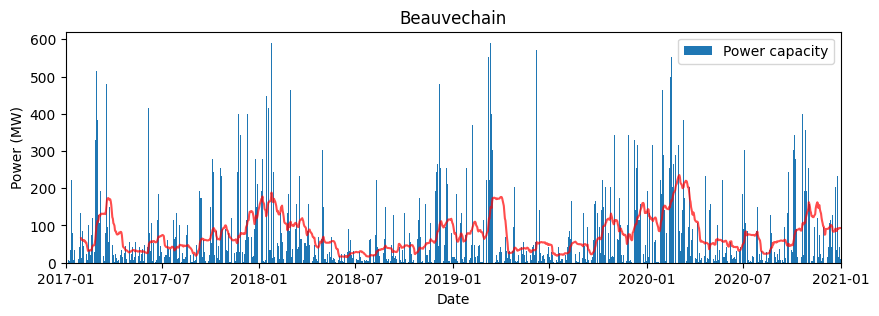

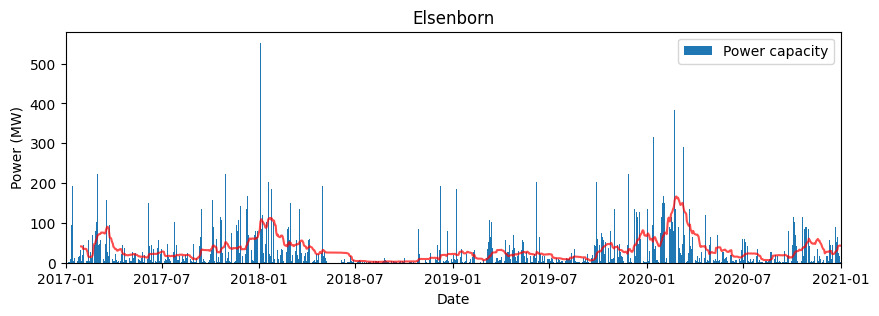

In [6]:
#histogram of electric power capacities in the given periode
def q2(df, title=''):
    plt.figure(figsize=(10, 3))
    plt.title(title)
    plt.bar(df['DATE'], df['PowerCapacity'], label='Power capacity')
    plt.plot(df['DATE'], df['PowerCapacity'].rolling(window=30).mean(), color='red', alpha=.7)
    plt.xlim(df['DATE'].min(), df['DATE'].max())
    plt.ylabel('Power (MW)')
    plt.xlabel('Date')
    plt.legend()


q2(df_be, title='Beauvechain')
q2(df_el, title='Elsenborn')

------------------------------------------------------------------------------------------------------

3.	Compare the following statistics of both sites and draw a first conclusions

•	Average and median powers for each farm (MW)

•	Standard deviations of powers, for each farm (MW)

•	5% and 95% percentiles of powers, for each farm (MW)

The average and standard deviation of the total power capacities (Beauvechain + Elsenborn).

------------------------------------------------------------------------------------------------------

In [7]:
# Code here



Comment briefly your results




------------------------------------------------------------------------------------------------------
4.	Fit Gamma and Inverse Gaussian distributions to wind speeds (in Km/h) in Beauvechain and Elsenborn. Estimate their parameters by log-likelihood maximization (MLE). Which distribution is the best one? Compare the histograms of winds with the fitted pdf’s on the same plot.
------------------------------------------------------------------------------------------------------

1.9444714656290532 8.742735648476259
1.3424859202875798 14.142916793197688


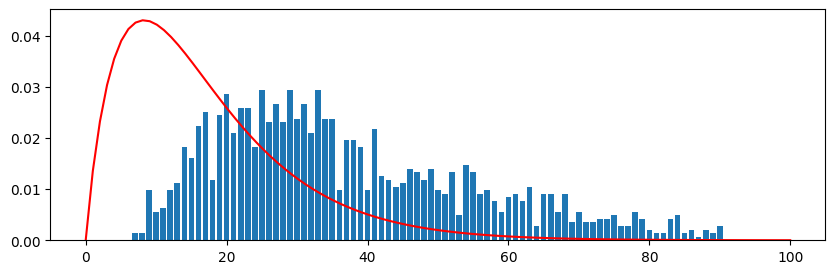

In [ ]:
## TO FIX

def q4(df, title=''):
    df_fgc = df.groupby(['FG'])['PowerCapacity'].count()

    a = (df_fgc.mean() ** 2) / df_fgc.var()
    b = df_fgc.mean() / df_fgc.var()
    
    print(a, 1/b)

    #X = np.linspace(df['FG'].min(), df['FG'].max(), 100)
    X = np.linspace(0, 100, 100)
    y = stats.gamma.pdf(X, a=a, scale=1/b)

    plt.figure(figsize=(10, 3))
    plt.title(title)
    plt.bar(df_fgc.index, df_fgc.values / df_fgc.sum())
    plt.plot(X, y, color='red')

q4(df_be)
q4(df_el)

Comment briefly your results



In [ ]:
# Code here, inverse Gaussian



Comment briefly your results


------------------------------------------------------------------------------------------------------
5.	Compute numerically for both sites, the following statistics 

•	Expected and median powers for each farm (MW)

•	Standard deviation of powers for each farm (MW)

•	5% and 95% percentiles of powers for each farm (MW)

Use the best distributions fitted in Question 4 (not observed values)

------------------------------------------------------------------------------------------------------

In [ ]:
# Code here



Comment briefly your results



------------------------------------------------------------------------------------------------------

6.	Same question as Q.4 but this time, you fit the best distribution by the methods of moments MM, (in Python). Compare parameter estimates and plot pdf’s obtained by MLE and MM for both wind farms.

------------------------------------------------------------------------------------------------------

In [ ]:
#code here



------------------------------------------------------------------------------------------------------

7.	Bootstrap 1000 times a sample of 500 daily speeds of wind for both wind farms and compute a 5% confidence interval for parameter(s) estimates for the best distribution of Question 4) modelling winds in Beauvechain. How do you interpret the results

------------------------------------------------------------------------------------------------------

In [ ]:
#code here



Comment briefly your results



------------------------------------------------------------------------------------------------------

8.	Let us denote by X the wind speed observed at Beauvechain on a day of the year. The winds observed over 30 days are denoted by (X1,…,X30). They are realizations of X, a random variable with the distribution fitted in Question 4. If M=max{ X1,…,X30},  

•	find the statistical law of M (equation requested, hint use the cdf of X) 

•	plot the pdf and cdf of M. 

•	Determine the wind value, p5, such that  P(M>p5)=95%.


------------------------------------------------------------------------------------------------------

Comment briefly your results



In [ ]:
# Code here

